In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
cd /content/drive/My\ Drive/SI 650 jignaw/Jigsaw-Unintended-Bias-in-Toxicity-Classification/

/content/drive/My Drive/SI 650 jignaw/Jigsaw-Unintended-Bias-in-Toxicity-Classification


In [0]:
!python -c 'import keras; print(keras.__version__)' 

Using TensorFlow backend.
2.2.5


# LSTM

In [0]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors


EMBEDDING_FILES = [
    './input/jigsaw-unintended-bias-in-toxicity-classification/crawl-300d-2M.gensim',
    './input/jigsaw-unintended-bias-in-toxicity-classification/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    print(x.shape)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    print(x.shape)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    print(x.shape)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    print(x.shape)
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    print(x.shape)
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    print(x.shape)
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    print(model.summary())
    return model

In [0]:


train_df = pd.read_csv('./input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test_df = pd.read_csv('./input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')

In [0]:
train_df.loc[train_df['target']==True].comment_text

714        Where do you get the Sour Grapes to say this i...
767        Dear world:\nJust a reminder that none of thes...
2551       The Liars Anonymous meeting today will be at 4...
3406       Marlene Pearson, do you really think Trump or ...
3431       these non compliant dispensary owners are grin...
                                 ...                        
1803504                       Your hypocrisy is showing too.
1803530    Please name producers that were chased out of ...
1803539    Judgemental music critics that can only listen...
1804362    Ah, the small minded, short sighted incompeten...
1804518    For some of these demonic possessed brats, a s...
Name: comment_text, Length: 4406, dtype: object

In [0]:

x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

In [0]:

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=True)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

1.8212822612548023

In [0]:


sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

In [0]:
train_df[IDENTITY_COLUMNS]

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1804869,False,False,False,False,False,False,False,False,False
1804870,False,False,False,False,False,False,False,False,False
1804871,False,False,False,False,False,False,False,False,False
1804872,False,False,False,False,False,False,False,False,False


In [0]:
len(tokenizer.word_index)

328389

In [0]:

embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embedding_matrix.shape

(328390, 600)

In [0]:


checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        model.save('model_'+str(model_idx)+'.h5')
        weights.append(2 ** global_epoch)

(?, ?, 600)
(?, ?, 256)
(?, ?, 256)
(?, ?, 256)
(?, ?, 256)
(?, ?, 256)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 600)    197034000   input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, None, 600)    0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, None, 256)    747520      spatial_dropout1d_3[0][0]        
____________________

# Inference 

In [0]:
import pickle
print("----------------------Loading LSTM Tokenizer----------------------")
tokenizer = pickle.load(open('./tokenizer_lstm.pickle','rb+'))

----------------------Loading LSTM Tokenizer----------------------


In [0]:
from keras.models import load_model
model1 = load_model('./model_1.h5')

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
from keras.preprocessing import text, sequence
MAX_LEN = 220
input_text = ['Thank you']
# tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=True)
# tokenizer.fit_on_texts(list(x_train) + list(input_text))

input_text = tokenizer.texts_to_sequences(input_text)
input_text = sequence.pad_sequences(input_text, maxlen=MAX_LEN)

In [0]:


prediction = model1.predict(input_text)[0].flatten()
prediction

array([0.00161421], dtype=float32)

array([0.4120933], dtype=float32)

# Evaluation

In [0]:

    




predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)

In [0]:
test_df_public = pd.read_csv('./input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')

In [0]:
test_df_public['label'] = [1 if i >= 0.5 else 0 for i in test_df_public['toxicity']]

In [0]:
submission_labels = [1 if i >= 0.5 else 0 for i in submission['prediction']]

In [0]:
np.sum(submission_labels==test_df_public['label'])/len(submission)

0.9443485408960132

In [0]:
test_df_private = pd.read_csv('./input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv')

In [0]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

print(classification_report(test_df_public['label'], submission_labels))
cf_matrix = precision_recall_fscore_support(test_df_public['label'], submission_labels)


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     89649
           1       0.62      0.74      0.68      7671

    accuracy                           0.94     97320
   macro avg       0.80      0.85      0.82     97320
weighted avg       0.95      0.94      0.95     97320



In [0]:
cf_matrix 

(array([0.97733274, 0.62407835]),
 array([0.96189584, 0.7392778 ]),
 array([0.96955285, 0.67681108]),
 array([89649,  7671]))

In [0]:
cf_matrix = (np.array([0.97733274, 0.62407835]),
 np.array([0.96189584, 0.7392778 ]),
 np.array([0.96955285, 0.67681108]),
 np.array([89649,  7671]))

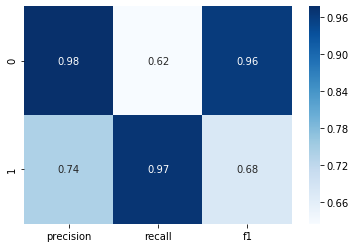

In [0]:
import seaborn as sns

sns.heatmap(np.array(cf_matrix[:3]).reshape(2,3),xticklabels=['precision','recall','f1'], annot=True, cmap="Blues")

In [0]:
test_df_public['toxicity']

NameError: ignored

In [0]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError


from sklearn.metrics import roc_curve,roc_auc_score, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_df_public['label'], submission['prediction'])

auc_keras = auc(fpr_keras, tpr_keras)



In [0]:
auc_keras

0.9674236336701766

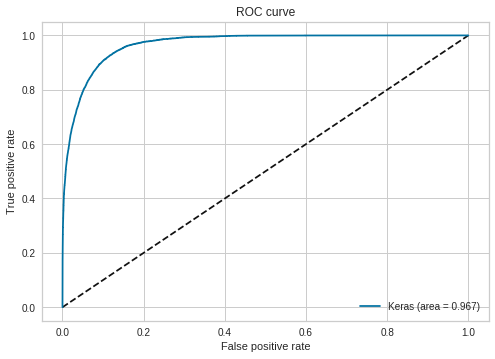

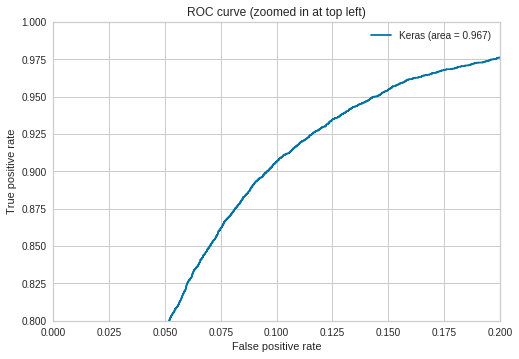

In [0]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## predict on public

In [0]:
x_test_private = test_df_private[TEXT_COLUMN].astype(str)


In [0]:
x_test_private = tokenizer.texts_to_sequences(x_test_private)

In [0]:
x_test_private = sequence.pad_sequences(x_test_private, maxlen=MAX_LEN)

In [0]:
submission_private = model.predict(x_test_private, batch_size=2048)[0].flatten()

In [0]:
submission_private_labels = [1 if i >= 0.5 else 0 for i in submission_private]

In [0]:
np.sum(submission_private_labels==test_df_public['label'])/len(submission_private_labels)

0.8236333744348541

# save tokenizer

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [0]:
# for tfidf
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
train = pd.read_csv("./input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test_df = pd.read_csv("./input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")


vectorizer = TfidfVectorizer(ngram_range=(1,3),lowercase=False,use_idf = False,max_features=8000)#tri-grams with tf-idf as value+
vectorizer.fit(train['comment_text'],test_df['comment_text'])

import pickle

with open('tokenizer_xgboost.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Word Cloud


In [0]:
toxicity_df = test_df_public[test_df_public['toxicity'] >= 0.1]

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:

toxicity_corpus = str().join(list(toxicity_df['comment_text']))


In [0]:
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
File = open("toxicity_corpus.txt", "w")
    
File.write(toxicity_corpus)
    
    
File.close()

In [0]:
extended_stop = ["people",'like','would','one','get','think','need','make','say']

In [0]:
extended_stop

['people', 'like', 'would', 'one', 'get', 'think', 'need', 'make', 'say']

In [0]:
wordcloud = WordCloud(stopwords=(list(stopwords_set)+extended_stop), background_color="white", scale=32 ).generate(toxicity_corpus)

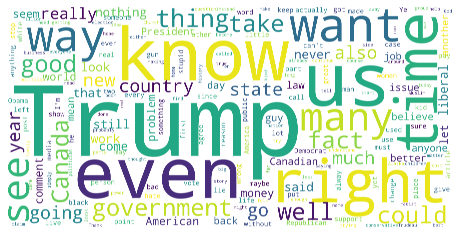

In [0]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()